# Context Extraction Error Rate
## TOC:
* [Speech To Text](#Speech-To-Text)
* [LUIS](#LUIS)
  * [CallSign Extraction](#LUIS-CallSign-Extraction)
  * [Intent Recognition](#LUIS-Intent-Recognition)
* [LUIS Version Compare](#LUIS-Version-Compare)
* [RML](#RML)
  * [CallSign Extraction](#RML-CallSign-Extraction)
  * [Intent Recognition](#RML-Intent-Recognition)
* [RML Version Compare](#RML-Version-Compare)
* [LUIS vs RML](#LUIS-vs-RML)
* [Auswertung](#Auswertung)

In [1]:
# autoreload for development; remove later :)
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import utils as utils
import context_utils as ctutils
import data_loader as dataloader

import word_error_rate as werutils
import text_cleanup as cleanup

In [3]:
# load json files from data folder
data = dataloader.load_rmlluis_data()

if len([dr for dr in data.datarecords if dr.context is None]) > 0:
    print('Warning: missing context file for files', [dr.name for dr in data.datarecords if dr.context is None])
    

dataLuisVs = dataloader.load_luisversions_data(['v0.1','v0.2-entities','v0.2-features','v0.3','v0.4'])
dataRmlVs = dataloader.load_rmlversions_data(['extracted-airline-nocheck','extracted-airline-check'])

## Labelled Data
Statistics about our data labels used for the following calculations

In [4]:
intents = utils.flatten([l['intent'] for l in data.labels])
intentsSet = set(intents)

intentCounts = {}
for intent in intentsSet:
    intentCounts[intent] = intents.count(intent)
    
intentLabels = {
    'squawk': 'Squawk',
    'flightlevel': 'Flight Level',
    'turn': 'Turn',
    'contact': 'Contact',
}

airlines = [l['airline'] for l in data.labels if l['airline']]
airlinesSet = set(airlines)
callsigns = [l['airline'] +' '+ l['flightnr'] for l in data.labels if l['airline'] and l['flightnr']]
callsignsSet = set(callsigns)

#airlineCounts = {}
#for airline in airlinesSet:
#    airlineCounts[airline] = airlines.count(airline)
#callsignCounts = {}
#for callsign in callsignsSet:
#    callsignCounts[callsign] = callsigns.count(callsign)

print('# labelled intents:\t\t', len(intentsSet), '\t', intentsSet)
print('# labelled messages:\t\t', len(data.labels), '\t', intentCounts)
print()
print('# single-intent messages:\t', len([l['intent'] for l in data.labels if len(l['intent']) == 1]))
print('# two-intent messages:\t\t', len([l['intent'] for l in data.labels if len(l['intent']) == 2]))
print()
print('# labelled airlines:\t\t', len(airlinesSet), '\tused in', len(airlines), 'messages')
print('# labelled callsigns:\t\t', len(callsignsSet), '\tused in', len(callsigns), 'messages')

# labelled intents:		 4 	 {'turn', 'flightlevel', 'squawk', 'contact'}
# labelled messages:		 102 	 {'turn': 26, 'flightlevel': 26, 'squawk': 26, 'contact': 26}

# single-intent messages:	 100
# two-intent messages:		 2

# labelled airlines:		 38 	used in 98 messages
# labelled callsigns:		 76 	used in 98 messages


### Airline Distribution
Distribution of airline names over the labeled data

'NICHT IM BERICHT'

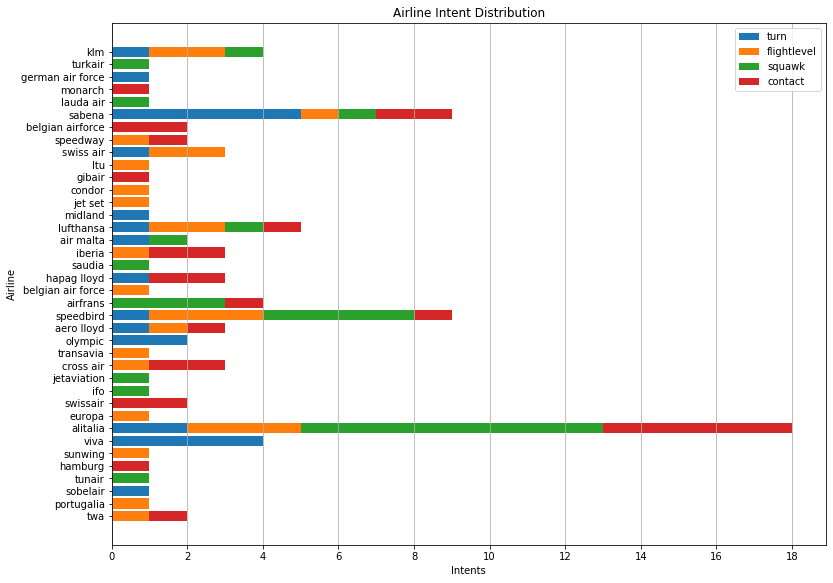

In [5]:
#airlines = [l['airline'] for l in data.labels if l['airline']]
#airlinesSet = set(airlines)

plt.figure(figsize=(12.8,9.6))
plt.subplot()

x_pos = [x for x, _ in enumerate(airlinesSet)]

countOffset = [0 for _ in airlinesSet]

for intent in intentsSet:
    airlinesIntent = [l['airline'] for l in data.labels if intent in l['intent']]
    airlinesIntentCount = [airlinesIntent.count(a) for a in airlinesSet]
    
    plt.barh(x_pos, airlinesIntentCount, label=intent, left=countOffset)
    
    countOffset = [a + b for a,b in zip(countOffset, airlinesIntentCount)] # add counts


plt.ylabel('Airline')
plt.xlabel('Intents')
plt.title('Airline Intent Distribution')
plt.legend(loc='best')

plt.gca().xaxis.get_major_locator().set_params(integer=True)
plt.xticks(np.arange(0, max(countOffset)+1, 2.0))

plt.grid(axis='x')
plt.xticks()
plt.yticks(x_pos, airlinesSet)

display('NICHT IM BERICHT')
plt.show()

## Speech To Text


In [6]:
# todo
# vergleich von n-best; wie stark unterscheiden sich die 3 varianten überhaupt?
# (WER vergleich zu Orginaltranskription)

# 3 mal das vorhandene WER diagramm nebeneinander als subplot
# gibt auch einen output als tabelle davon (zurzeti in text file geoutputet)
# optional: 3 balken mit gesamt WER

stt_nbests = dataloader.load_stt_nbests()
print('# stt nbest files loaded:\t', len(stt_nbests))

nbest_wers = [None] * len(stt_nbests)
for i, current_nbest in enumerate(stt_nbests):
    human_trascript = dataloader.load_human_transcription(current_nbest.name)
    current_wers = [None] * len(current_nbest.transcriptions)
    
    for j, current_transcription in enumerate(current_nbest.transcriptions):
        cleaned_human_transcript = cleanup.clean_up_text(human_trascript)
        cleaned_current_transcript = cleanup.clean_up_text(current_transcription)
        current_wers[j] = werutils.word_error_rate(cleaned_human_transcript, cleaned_current_transcript)
    
    nbest_wers[i] = current_wers

print('# stt wers calculated:\t\t', len(nbest_wers))


avg_wer = np.zeros(3, dtype = float)
avg_items_counter = np.zeros(3, dtype = float)
for i,wer in enumerate(nbest_wers):
    for j in range(len(nbest_wers[i])):
        avg_wer[j] += nbest_wers[i][j]
        avg_items_counter[j] += 1

for i in range(len(avg_wer)):
    avg_wer[i] /= avg_items_counter[i]

print(avg_wer)

# stt nbest files loaded:	 102
# stt wers calculated:		 102
[ 8.55433172 12.68889751 13.32469423]


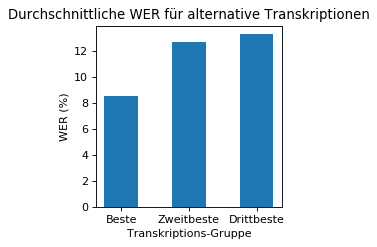

In [7]:
plt.figure(figsize=(3, 3), dpi=80)
plt.subplot()

wer_names = ['Beste', 'Zweitbeste', 'Drittbeste']
plt.bar(wer_names, avg_wer, width=0.5)
plt.ylabel('WER (%)')
plt.xlabel('Transkriptions-Gruppe')
plt.title('Durchschnittliche WER für alternative Transkriptionen')
plt.show()

In [8]:
nbest_wers = [None] * len(stt_nbests)
for i, current_nbest in enumerate(stt_nbests):
    cleaned_nbest1 = cleanup.clean_up_text(current_nbest.transcriptions[0])
    cleaned_nbest2 = cleanup.clean_up_text(current_nbest.transcriptions[1])
    if len(current_nbest.transcriptions) > 2:
        cleaned_nbest3 = cleanup.clean_up_text(current_nbest.transcriptions[2])

    current_wers = [None] * 3
    current_wers[0] = werutils.word_error_rate(cleaned_nbest1, cleaned_nbest2)
    current_wers[1] = werutils.word_error_rate(cleaned_nbest1, cleaned_nbest3)
    if len(current_nbest.transcriptions) > 2:
        current_wers[2] = werutils.word_error_rate(cleaned_nbest2, cleaned_nbest3)

    nbest_wers[i] = current_wers

print('# stt wers calculated:\t\t', len(nbest_wers))

avg_wer = np.zeros(3, dtype = float)
avg_items_counter = np.zeros(3, dtype = float)
for i,wer in enumerate(nbest_wers):
        for j in range(len(nbest_wers[i])):
            if nbest_wers[i][j] is not None:
                avg_wer[j] += nbest_wers[i][j]
                avg_items_counter[j] += 1

for i in range(len(avg_wer)):
    avg_wer[i] /= avg_items_counter[i]


print('1 vs 2:\t\t', avg_wer[0])
print('1 vs 3:\t\t', avg_wer[1])
print('2 vs 3:\t\t', avg_wer[2])

# stt wers calculated:		 102
1 vs 2:		 7.870054233859899
1 vs 3:		 9.339514293927481
2 vs 3:		 10.46568671993803


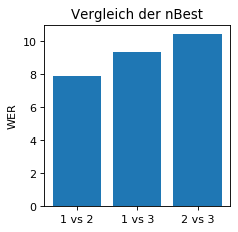

In [9]:
plt.figure(figsize=(3, 3), dpi=80)
plt.subplot()

wer_names = ['1 vs 2', '1 vs 3', '2 vs 3']
plt.bar(wer_names, avg_wer)
plt.ylabel('WER')
plt.title('Vergleich der nBest')
plt.show()

## LUIS

In [10]:
#intents = utils.flatten([l['intent'] for l in data.labels])
intents = list(set(intents))

luisCallsignResults = {
    'fullCallSign': 0,
    'flightNumerOnly': 0,
    'airlineOnly': 0,
    'allInvalid': 0,
}

luisCallSignDistance = {
    'airline': {},
    'flightNumber': {},
}

# valid:   alle Intents einer Message wurden korrekt erkannt
# invalid: mind. ein Intent einer Message wurde falsch erkannt
luisIntentResults = {
    'valid': [0],
    'invalid': [0],
}

# truepos:  True Positive  -> Intent vorhanden und (korrekt) erkannt
# trueneg:  True Negative  -> Intent nicht vorhanden und (korrekt) nicht erkannt
# falsepos: False Positive -> Intent nicht vorhanden aber erkannt
# falseneg: False Negative -> Intent vorhanden aber nicht erkannt
luisPerIntentResults = {
    'intent': intents,
    'truepos': [0 for i in intents],
    'trueneg': [0 for i in intents],
    'falsepos': [0 for i in intents],
    'falseneg': [0 for i in intents],
}

for rec in data.datarecords:
    if rec.context is None:
        continue
    
    luisContext = rec.context[0]['LuisContext'] # 0 -> use best speech2text result only
    
    # compare extracted data with labels
    luisAirlineValid, luisFlightnrValid, luisAirlineLevenshtein, luisFlightnrLevenshtein = ctutils.check_callsign(luisContext, rec.label)
    luisIntentsValid, luisDetectedIntents, luisMissingIntents, luisRedundantIntents = ctutils.check_intents(luisContext, rec.label)
    
    # set luisCallsignResults
    if luisFlightnrValid and luisAirlineValid:
        luisCallsignResults['fullCallSign'] += 1
    elif luisFlightnrValid and not luisAirlineValid:
        luisCallsignResults['flightNumerOnly'] += 1
    elif not luisFlightnrValid and luisAirlineValid:
        luisCallsignResults['airlineOnly'] += 1
    else:
        luisCallsignResults['allInvalid'] += 1
    
    key = str(int(luisAirlineLevenshtein)) if luisAirlineLevenshtein is not None and int(luisAirlineLevenshtein) < 10 else '≥10'
    luisCallSignDistance['airline'][key] = luisCallSignDistance['airline'].get(key, 0) + 1
    key = str(int(luisFlightnrLevenshtein)) if luisFlightnrLevenshtein is not None and int(luisFlightnrLevenshtein) < 4 else '≥4'
    luisCallSignDistance['flightNumber'][key] = luisCallSignDistance['flightNumber'].get(key, 0) + 1
    
    
    # set luisIntentResults
    luisIntentResults['valid' if luisIntentsValid else 'invalid'][0] += 1
    
    # set luisPerIntentResults
    for i in range(len(intents)):
        if intents[i] in luisMissingIntents:
            luisPerIntentResults['falseneg'][i] += 1
        elif intents[i] in luisRedundantIntents:
            luisPerIntentResults['falsepos'][i] += 1
        elif intents[i] in luisDetectedIntents:
            luisPerIntentResults['truepos'][i] += 1
        else:
            luisPerIntentResults['trueneg'][i] += 1


### LUIS CallSign Extraction
Count of fully recognized callsigns and correctly recognized airline names or flight numbers

In [11]:
pd.DataFrame({
    'fullCallSign': [luisCallsignResults['fullCallSign']],
    'flightNumerOnly': [luisCallsignResults['flightNumerOnly']],
    'airlineOnly': [luisCallsignResults['airlineOnly']],
    'allInvalid': [luisCallsignResults['allInvalid']],
})

,fullCallSign,flightNumerOnly,airlineOnly,allInvalid
0,64,9,9,20


'NICHT IM BERICHT'

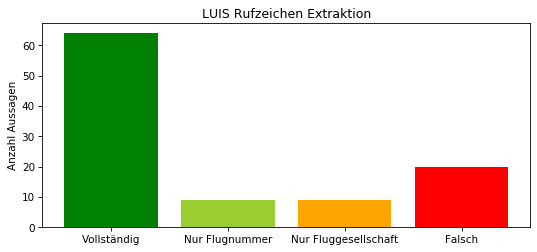

In [12]:
plt.figure(figsize=(8.4, 3.6), dpi=75)
plt.subplot()

labels = ['Vollständig', 'Nur Flugnummer', 'Nur Fluggesellschaft', 'Falsch']
colors = ['green',  'yellowgreen', 'orange', 'red']
values = [luisCallsignResults[cr] for cr in ['fullCallSign','flightNumerOnly','airlineOnly','allInvalid']]

plt.title('LUIS Rufzeichen Extraktion')
plt.ylabel('Anzahl Aussagen')

plt.bar(labels, values, color=colors)

display('NICHT IM BERICHT')
plt.show()

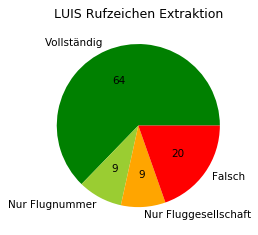

In [13]:
plt.figure(figsize=(4.8, 3.6), dpi=75)
plt.subplot()

labels = ['Vollständig', 'Nur Flugnummer', 'Nur Fluggesellschaft', 'Falsch']
colors = ['green',  'yellowgreen', 'orange', 'red']
values = [luisCallsignResults[cr] for cr in ['fullCallSign','flightNumerOnly','airlineOnly','allInvalid']]
total = sum(values)

plt.title('LUIS Rufzeichen Extraktion')

plt.pie(values, labels=labels, colors=colors, autopct=lambda s: '{:.0f}'.format(s * total / 100))
plt.show()

**Levenshtein Distanz**

In [14]:
for k in luisCallSignDistance.keys():
    display(pd.DataFrame({k: luisCallSignDistance[k]}).sort_index())

,airline
0,73
1,4
3,2
4,2
9,1
≥10,20


,flightNumber
0,73
1,8
2,1
≥4,20


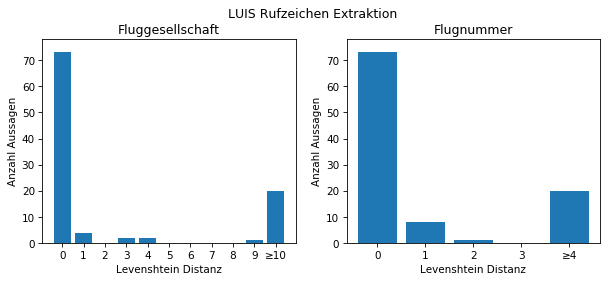

In [15]:
plt.figure(figsize=(9.6, 3.6), dpi=75)
plt.subplot(1, 2, 1)

labels = [str(k) for k in list(range(0,10))] + ['≥10']

values = [luisCallSignDistance['airline'].get(ld, 0) for ld in labels]
plt.bar(labels, values)

plt.title('Fluggesellschaft')
plt.ylabel('Anzahl Aussagen')
plt.xlabel('Levenshtein Distanz')
plt.ylim(top=78)

plt.subplot(1, 2, 2)

labels = [str(k) for k in list(range(0,4))] + ['≥4']

values = [luisCallSignDistance['flightNumber'].get(ld, 0) for ld in labels]
plt.bar(labels, values)

plt.title('Flugnummer')
plt.ylabel('Anzahl Aussagen')
plt.xlabel('Levenshtein Distanz')
plt.ylim(top=78)

plt.suptitle('LUIS Rufzeichen Extraktion', y=1)
plt.show()

'NICHT IM BERICHT'

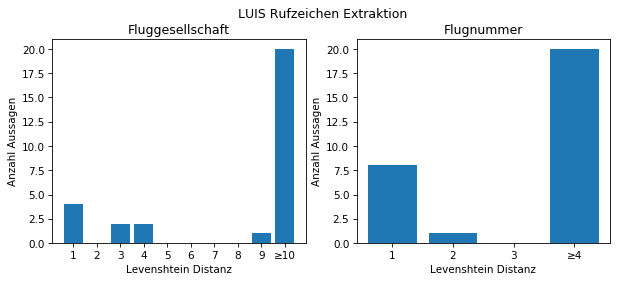

In [16]:
plt.figure(figsize=(9.6, 3.6), dpi=75)
plt.subplot(1, 2, 1)

labels = [str(k) for k in list(range(1,10))] + ['≥10']

values = [luisCallSignDistance['airline'].get(ld, 0) for ld in labels]
plt.bar(labels, values)

plt.title('Fluggesellschaft')
plt.ylabel('Anzahl Aussagen')
plt.xlabel('Levenshtein Distanz')

plt.subplot(1, 2, 2)

labels = [str(k) for k in list(range(1,4))] + ['≥4']

values = [luisCallSignDistance['flightNumber'].get(ld, 0) for ld in labels]
plt.bar(labels, values)

plt.title('Flugnummer')
plt.ylabel('Anzahl Aussagen')
plt.xlabel('Levenshtein Distanz')

plt.suptitle('LUIS Rufzeichen Extraktion', y=1)

display('NICHT IM BERICHT')
plt.show()

In [17]:
#plt.figure(figsize=(8.4, 3.6), dpi=75)
#plt.subplot()
#
#labels = [str(k) for k in list(range(1,10))] + ['≥10']
#
#N = len(labels)
#ind = np.arange(N)
#width = 0.3
#
#values = [luisCallSignDistance['airline'].get(ld, 0) for ld in labels]
#plt.bar(ind, values, width, label='Fluggesellschaft')
#values = [luisCallSignDistance['flightNumber'].get(ld, 0) for ld in labels]
#plt.bar(ind + width, values, width, label='Flugnummer')
#
#plt.xticks(ind + 0.5 * width, labels)
#plt.gca().yaxis.get_major_locator().set_params(integer=True)
#
#plt.title('LUIS Rufzeichen Extraktion Levenshtein Distanz')
#plt.ylabel('Anzahl Aussagen')
#plt.xlabel('Levenshtein Distanz')
#plt.legend(loc='best')
#
#display('NICHT IM BERICHT')
#plt.show()

### LUIS Intent Recognition
Count of messages where all intents were recognized correctly

In [18]:
display('Anzahl Nachrichten mit korrekt vs falsch erkannter Absicht')
pd.DataFrame(luisIntentResults)

'Anzahl Nachrichten mit korrekt vs falsch erkannter Absicht'

,valid,invalid
0,87,15


'NICHT IM BERICHT'

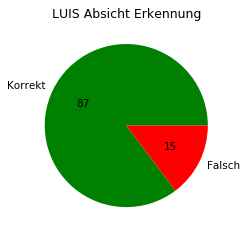

In [19]:
plt.figure(figsize=(4.8, 3.6), dpi=75)
plt.subplot()

labels = ['Korrekt', 'Falsch']
colors = ['g', 'r']
values = [luisIntentResults[k][0] for k in ['valid', 'invalid']]
total = sum(values)

plt.pie(values, labels=labels, colors=colors, autopct=lambda s: '{:.0f}'.format(s * total / 100))
plt.title('LUIS Absicht Erkennung')

display('NICHT IM BERICHT')
plt.show()

'NICHT IM BERICHT'

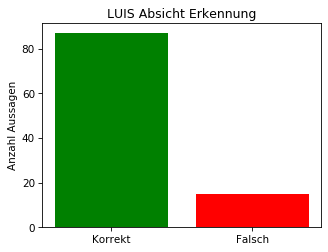

In [20]:
plt.figure(figsize=(4.8, 3.6), dpi=75)
plt.subplot()

labels = ['Korrekt', 'Falsch']
colors = ['g', 'r']
values = [luisIntentResults[k][0] for k in ['valid', 'invalid']]

plt.bar(labels, values, color=colors)
plt.title('LUIS Absicht Erkennung')
plt.ylabel('Anzahl Aussagen')

display('NICHT IM BERICHT')
plt.show()

**Sensitivity and Specificity of the LUIS intent recognition**

In [21]:
pd.DataFrame(luisPerIntentResults)

,intent,truepos,trueneg,falsepos,falseneg
0,turn,21,76,0,5
1,flightlevel,21,75,1,5
2,squawk,24,76,0,2
3,contact,25,76,0,1


'NICHT IM BERICHT'

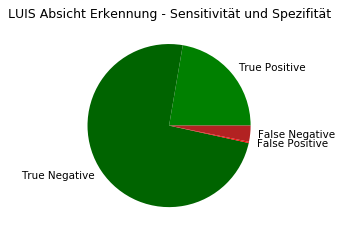

In [22]:
plt.figure(figsize=(4.8, 3.6), dpi=75)
plt.subplot()

labels = ['True Positive', 'True Negative', 'False Positive', 'False Negative']
colors = ['green',  'darkgreen', 'red', 'firebrick']
values = np.array([luisPerIntentResults[c] for c in ['truepos','trueneg','falsepos','falseneg']]).sum(axis=1)

#labels = ['True Positive', 'False Positive', 'False Negative']
#colors = ['green',  'red', 'firebrick']
#values = np.array([luisPerIntentResults[c] for c in ['truepos','falsepos','falseneg']]).sum(axis=1)

plt.pie(values, labels=labels, colors=colors)

plt.title('LUIS Absicht Erkennung - Sensitivität und Spezifität')

display('NICHT IM BERICHT')
plt.show()

'NICHT IM BERICHT'

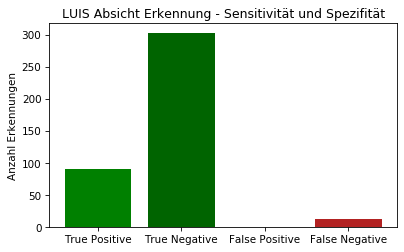

In [23]:
plt.figure(figsize=(6, 3.6), dpi=75)
plt.subplot()

labels = ['True Positive', 'True Negative', 'False Positive', 'False Negative']
colors = ['green',  'darkgreen', 'red', 'firebrick']
values = [sum(luisPerIntentResults[c]) for c in ['truepos','trueneg','falsepos','falseneg']]


plt.title('LUIS Absicht Erkennung - Sensitivität und Spezifität')
plt.ylabel('Anzahl Erkennungen')

plt.bar(labels, values, color=colors)

display('NICHT IM BERICHT')
plt.show()

'NICHT IM BERICHT'

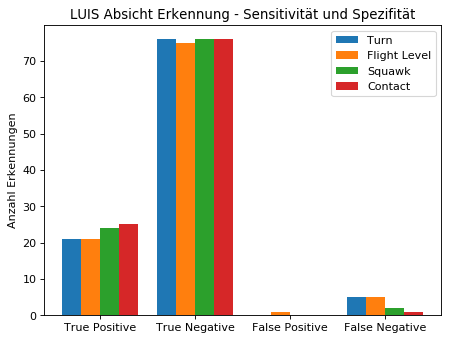

In [24]:
plt.figure(figsize=(6.4, 4.8), dpi=80)
plt.subplot()

N = 4

ind = np.arange(N) 
width = 0.2

for i in range(len(luisPerIntentResults['intent'])):
    intentValues = [luisPerIntentResults[c][i] for c in ['truepos','trueneg','falsepos','falseneg']]
    plt.bar(ind + (width * i), intentValues, width, label=intentLabels[luisPerIntentResults['intent'][i]])

plt.title('LUIS Absicht Erkennung - Sensitivität und Spezifität')
plt.ylabel('Anzahl Erkennungen')

plt.xticks(ind + 1.5 * width, ('True Positive', 'True Negative', 'False Positive', 'False Negative'))
plt.legend(loc='best')

display('NICHT IM BERICHT')
plt.show()

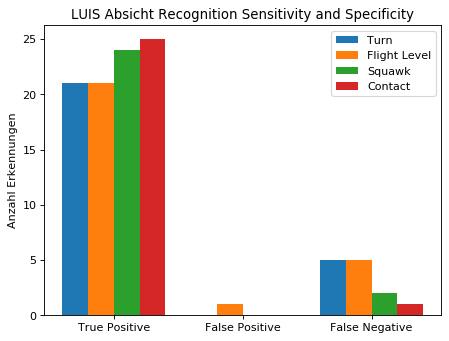

In [25]:
plt.figure(figsize=(6.4, 4.8), dpi=80)
plt.subplot()

N = 3

ind = np.arange(N) 
width = 0.2

for i in range(len(luisPerIntentResults['intent'])):
    intentValues = [luisPerIntentResults[c][i] for c in ['truepos','falsepos','falseneg']]
    plt.bar(ind + (width * i), intentValues, width, label=intentLabels[luisPerIntentResults['intent'][i]])

plt.ylabel('Anzahl Erkennungen')
plt.title('LUIS Absicht Recognition Sensitivity and Specificity')

plt.xticks(ind + 1.5 * width, ('True Positive', 'False Positive', 'False Negative'))
plt.legend(loc='best')
plt.show()

## LUIS Version Compare

In [26]:
# Versionsvergleich
# drei mal "Sensitivity and Specificity" nebeneinander
# oder noch eher: als stacked diagramm

# Confidence vergleich mit gleichem Diagramm, aber statt Count durchschnittliche Confidence
#dataLuisVersions.datarecords

#dataLuisVs

In [27]:
#intents = utils.flatten([l['intent'] for l in dataLuisVs.labels])
intents = list(set(intents))

luisVsCallsignResults = {v:{
    'fullCallSign': 0,
    'flightNumerOnly': 0,
    'airlineOnly': 0,
    'allInvalid': 0,
} for v in dataLuisVs.versions}

# valid:   alle Intents einer Message wurden korrekt erkannt
# invalid: mind. ein Intent einer Message wurde falsch erkannt
luisVsIntentResults = {v:{
    'valid': 0,
    'invalid': 0,
} for v in dataLuisVs.versions}

luisVsPerIntentResults = {v:{
    'intent': intents,
    'scores': [[] for i in intents],
    'scoreAvg': [0 for i in intents]
} for v in dataLuisVs.versions}

for rec in dataLuisVs.datarecords:
    if rec.contexts is None:
        continue
    
    for version in dataLuisVs.versions:
        if rec.contexts[version] is None:
            continue
        
        luisContext = rec.contexts[version][0]['LuisContext']
    
        # compare extracted data with labels
        luisAirlineValid, luisFlightnrValid, luisAirlineLevenshtein, luisFlightnrLevenshtein = ctutils.check_callsign(luisContext, rec.label)
        luisIntentsValid, luisDetectedIntents, luisMissingIntents, luisRedundantIntents = ctutils.check_intents(luisContext, rec.label)

        # set luisCallsignResults
        if luisFlightnrValid and luisAirlineValid:
            luisVsCallsignResults[version]['fullCallSign'] += 1
        elif luisFlightnrValid and not luisAirlineValid:
            luisVsCallsignResults[version]['flightNumerOnly'] += 1
        elif not luisFlightnrValid and luisAirlineValid:
            luisVsCallsignResults[version]['airlineOnly'] += 1
        else:
            luisVsCallsignResults[version]['allInvalid'] += 1


        # set luisIntentResults
        luisVsIntentResults[version]['valid' if luisIntentsValid else 'invalid'] += 1
        
        # set luisPerIntentResults
        dataIntents = ctutils._get_intents(luisContext)
        for i in range(len(intents)):
            if intents[i] in rec.label['intent']: # if message contains this intent
                score = 0
                if dataIntents[intents[i]] is not None:
                    score = dataIntents[intents[i]]['Score']
                luisVsPerIntentResults[version]['scores'][i].append(score)
                
# update luisVsPerIntentResults scoreAvg
for version in luisVsPerIntentResults.keys():
    for i in range(len(intents)):
        luisVsPerIntentResults[version]['scoreAvg'][i] = (sum(luisVsPerIntentResults[version]['scores'][i]) / len(luisVsPerIntentResults[version]['scores'][i]))

In [28]:
# Rufzeichen Korrekt
# Flugnummer Korrekt, Fluggesellschaft Inkorrekt
# Flugnummer Inkorrekt, Fluggesellschaft Korrekt
# Alles Falsch
pd.DataFrame(luisVsCallsignResults)

,v0.1,v0.2-entities,v0.2-features,v0.3,v0.4
fullCallSign,62,62,62,62,64
flightNumerOnly,11,11,11,11,9
airlineOnly,9,9,9,9,9
allInvalid,20,20,20,20,20


In [29]:
pd.DataFrame({v:{intentLabels[intents[i]]:luisVsPerIntentResults[v]['scoreAvg'][i] for i in range(len(intents))} for v in dataLuisVs.versions})

,v0.1,v0.2-entities,v0.2-features,v0.3,v0.4
Turn,0.664814,0.664814,0.804489,0.804489,0.804489
Flight Level,0.754893,0.754893,0.808667,0.808667,0.808667
Squawk,0.839391,0.839391,0.909202,0.909202,0.909202
Contact,0.746645,0.746645,0.956606,0.956606,0.956606


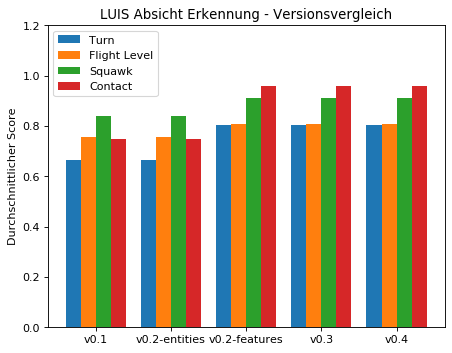

In [30]:
plt.figure(figsize=(6.4, 5), dpi=80)
plt.subplot()

N = len(dataLuisVs.versions)

ind = np.arange(N) 
width = 0.2

for i in range(len(intents)):
    intentValues = [luisVsPerIntentResults[v]['scoreAvg'][i] for v in dataLuisVs.versions]
    plt.bar(ind + (width * i), intentValues, width, label=intentLabels[intents[i]])

plt.ylabel('Durchschnittlicher Score')
plt.title('LUIS Absicht Erkennung - Versionsvergleich')

plt.xticks(ind + 1.5 * width, [v for v in dataLuisVs.versions])
plt.legend(loc='best')
plt.ylim(0,1.2)
plt.show()


'NICHT IM BERICHT'

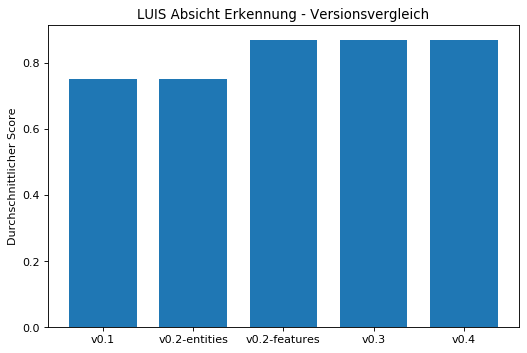

In [31]:
plt.figure(figsize=(7.6, 5), dpi=80)
plt.subplot()

width = 0.75

labels = [v for v in dataLuisVs.versions]
values = [sum([luisVsPerIntentResults[v]['scoreAvg'][i] for i in range(len(intents))])/len(intents) for v in dataLuisVs.versions]
plt.bar(labels, values, width)

plt.ylabel('Durchschnittlicher Score')
plt.title('LUIS Absicht Erkennung - Versionsvergleich')

display('NICHT IM BERICHT')
plt.show()

In [32]:
pd.DataFrame(luisVsIntentResults)

,v0.1,v0.2-entities,v0.2-features,v0.3,v0.4
valid,85,85,87,87,87
invalid,17,17,15,15,15


## RML
Validierung der Intent Erkennung

_Als Input dient die von Speech To Text erkannte Message (bestes Resultat)_

In [33]:
#intents = utils.flatten([l['intent'] for l in data.labels])
intents = list(set(intents))

rmlCallsignResults = {
    'fullCallSign': 0,
    'flightNumerOnly': 0,
    'airlineOnly': 0,
    'allInvalid': 0,
}

rmlCallSignDistance = {
    'airline': {},
    'flightNumber': {},
}

# valid:   alle Intents einer Message wurden korrekt erkannt
# invalid: mind. ein Intent einer Message wurde falsch erkannt
rmlIntentResults = {
    'valid': [0],
    'invalid': [0],
}

# truepos:  True Positive  -> Intent vorhanden und (korrekt) erkannt
# trueneg:  True Negative  -> Intent nicht vorhanden und (korrekt) nicht erkannt
# falsepos: False Positive -> Intent nicht vorhanden aber erkannt
# falseneg: False Negative -> Intent vorhanden aber nicht erkannt
rmlPerIntentResults = {
    'intent': intents,
    'truepos': [0 for i in intents],
    'trueneg': [0 for i in intents],
    'falsepos': [0 for i in intents],
    'falseneg': [0 for i in intents],
}

for rec in data.datarecords:
    if rec.context is None:
        continue
    
    rmlContext = rec.context[0]['RmlContext'] # 0 -> use best speech2text result only
    
    # compare extracted data with labels
    rmlAirlineValid, rmlFlightnrValid, rmlAirlineLevenshtein, rmlFlightnrLevenshtein = ctutils.check_callsign(rmlContext, rec.label)
    rmlIntentsValid, rmlDetectedIntents, rmlMissingIntents, rmlRedundantIntents = ctutils.check_intents(rmlContext, rec.label)
    
    # set rmlCallsignResults
    if rmlFlightnrValid and rmlAirlineValid:
        rmlCallsignResults['fullCallSign'] += 1
    elif rmlFlightnrValid and not rmlAirlineValid:
        rmlCallsignResults['flightNumerOnly'] += 1
    elif not rmlFlightnrValid and rmlAirlineValid:
        rmlCallsignResults['airlineOnly'] += 1
    else:
        rmlCallsignResults['allInvalid'] += 1
    
    key = str(int(rmlAirlineLevenshtein)) if rmlAirlineLevenshtein is not None and int(rmlAirlineLevenshtein) < 10 else '≥10'
    rmlCallSignDistance['airline'][key] = rmlCallSignDistance['airline'].get(key, 0) + 1
    key = str(int(rmlFlightnrLevenshtein)) if rmlFlightnrLevenshtein is not None and int(rmlFlightnrLevenshtein) < 4 else '≥4'
    rmlCallSignDistance['flightNumber'][key] = rmlCallSignDistance['flightNumber'].get(key, 0) + 1
    
    # set rmlIntentResults
    rmlIntentResults['valid' if rmlIntentsValid else 'invalid'][0] += 1
    
    # set rmlPerIntentResults
    for i in range(len(intents)):
        if intents[i] in rmlMissingIntents:
            rmlPerIntentResults['falseneg'][i] += 1
        elif intents[i] in rmlRedundantIntents:
            rmlPerIntentResults['falsepos'][i] += 1
        elif intents[i] in rmlDetectedIntents:
            rmlPerIntentResults['truepos'][i] += 1
        else:
            rmlPerIntentResults['trueneg'][i] += 1
            

### RML CallSign Extraction
Count of fully recognized callsigns and correctly recognized airline names or flight numbers

In [34]:
pd.DataFrame({
    'fullCallSign': [rmlCallsignResults['fullCallSign']],
    'flightNumerOnly': [rmlCallsignResults['flightNumerOnly']],
    'airlineOnly': [rmlCallsignResults['airlineOnly']],
    'allInvalid': [rmlCallsignResults['allInvalid']],
})

,fullCallSign,flightNumerOnly,airlineOnly,allInvalid
0,69,19,12,2


'NICHT IM BERICHT'

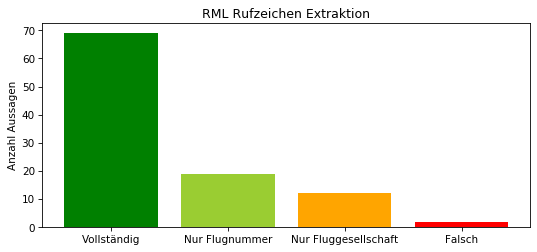

In [35]:
# Callsign Valid | Callsign Invalid
# -              | Airline Invalid / Flightnr Invalid / Both Invalid


plt.figure(figsize=(8.4, 3.6), dpi=75)
plt.subplot()

labels = ['Vollständig', 'Nur Flugnummer', 'Nur Fluggesellschaft', 'Falsch']
colors = ['green',  'yellowgreen', 'orange', 'red']
values = [rmlCallsignResults[cr] for cr in ['fullCallSign','flightNumerOnly','airlineOnly','allInvalid']]

plt.title('RML Rufzeichen Extraktion')
plt.ylabel('Anzahl Aussagen')

plt.bar(labels, values, color=colors)

display('NICHT IM BERICHT')
plt.show()

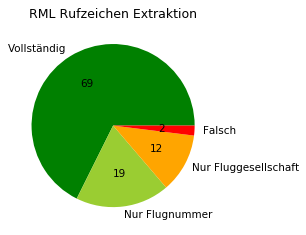

In [36]:
# Zutaten Kuchen:
# 100g Full Callsign Korrekt
# 75g  Nur Flugnummer korrekt
# 50g  Nur Airline Korrekt
# 1 EL Ungültig

plt.figure(figsize=(4.8, 3.6), dpi=75)
plt.subplot()

labels = ['Vollständig', 'Nur Flugnummer', 'Nur Fluggesellschaft', 'Falsch']
colors = ['green',  'yellowgreen', 'orange', 'red']
values = [rmlCallsignResults[cr] for cr in ['fullCallSign','flightNumerOnly','airlineOnly','allInvalid']]
total = sum(values)

plt.title('RML Rufzeichen Extraktion')

plt.pie(values, labels=labels, colors=colors, autopct=lambda s: '{:.0f}'.format(s * total / 100))
plt.show()

**Levenshtein Distanz**

In [37]:
for k in rmlCallSignDistance.keys():
    display(pd.DataFrame({k: rmlCallSignDistance[k]}).sort_index())

,airline
0,81
1,5
2,1
3,2
4,2
6,3
7,1
8,2
9,1
≥10,4


,flightNumber
0,88
1,10
3,3
≥4,1


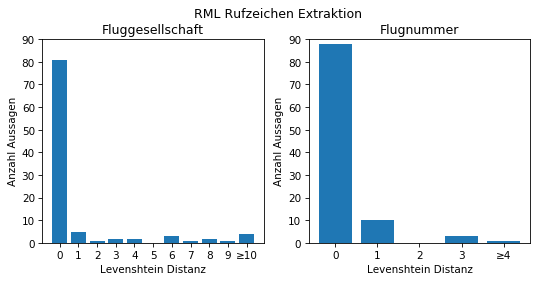

In [38]:
plt.figure(figsize=(8.4, 3.6), dpi=75)
plt.subplot(1, 2, 1)

labels = [str(k) for k in list(range(0,10))] + ['≥10']

values = [rmlCallSignDistance['airline'].get(ld, 0) for ld in labels]
plt.bar(labels, values)

plt.title('Fluggesellschaft')
plt.ylabel('Anzahl Aussagen')
plt.xlabel('Levenshtein Distanz')
plt.ylim(top=90)

plt.subplot(1, 2, 2)

labels = [str(k) for k in list(range(0,4))] + ['≥4']

values = [rmlCallSignDistance['flightNumber'].get(ld, 0) for ld in labels]
plt.bar(labels, values)

plt.title('Flugnummer')
plt.ylabel('Anzahl Aussagen')
plt.xlabel('Levenshtein Distanz')
plt.ylim(top=90)

plt.suptitle('RML Rufzeichen Extraktion', y=1)
plt.show()

'NICHT IM BERICHT'

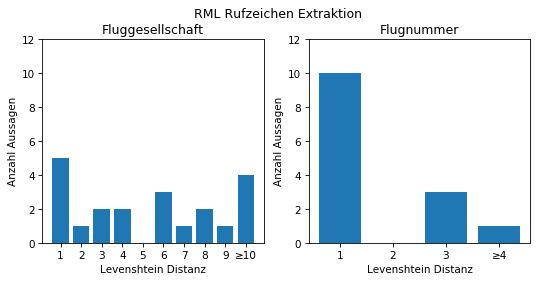

In [39]:
plt.figure(figsize=(8.4, 3.6), dpi=75)
plt.subplot(1, 2, 1)

labels = [str(k) for k in list(range(1,10))] + ['≥10']

values = [rmlCallSignDistance['airline'].get(ld, 0) for ld in labels]
plt.bar(labels, values)

plt.title('Fluggesellschaft')
plt.ylabel('Anzahl Aussagen')
plt.xlabel('Levenshtein Distanz')
plt.ylim(top=12)

plt.subplot(1, 2, 2)

labels = [str(k) for k in list(range(1,4))] + ['≥4']

values = [rmlCallSignDistance['flightNumber'].get(ld, 0) for ld in labels]
plt.bar(labels, values)

plt.title('Flugnummer')
plt.ylabel('Anzahl Aussagen')
plt.xlabel('Levenshtein Distanz')
plt.ylim(top=12)

plt.suptitle('RML Rufzeichen Extraktion', y=1)

display('NICHT IM BERICHT')
plt.show()

In [40]:
#plt.figure(figsize=(8.4, 3.6), dpi=75)
#plt.subplot()
#
#keys = [int(v) for v in rmlCallSignDistance['airline'].keys() if v != 'invalid']
#labels = [str(k) for k in list(range(1,max(keys)+1))] + ['invalid']
#
#N = len(labels)
#ind = np.arange(N)
#width = 0.3
#
#values = [rmlCallSignDistance['airline'].get(ld, 0) for ld in labels]
#plt.bar(ind, values, width, label='Fluggesellschaft')
#values = [rmlCallSignDistance['flightNumber'].get(ld, 0) for ld in labels]
#plt.bar(ind + width, values, width, label='Flugnummer')
#
#plt.xticks(ind + 0.5 * width, labels)
#plt.gca().yaxis.get_major_locator().set_params(integer=True)
#
#plt.title('RML Rufzeichen Extraktion Levenshtein Distanz')
#plt.ylabel('Anzahl Aussagen')
#plt.xlabel('Levenshtein Distanz')
#plt.legend(loc='best')
#
#plt.show()

### RML Intent Recognition
Count of messages where all intents were recognized correctly

In [41]:
display('Anzahl Nachrichten mit korrekt vs falsch erkannter Absicht')
pd.DataFrame(rmlIntentResults)

'Anzahl Nachrichten mit korrekt vs falsch erkannter Absicht'

,valid,invalid
0,78,24


'NICHT IM BERICHT'

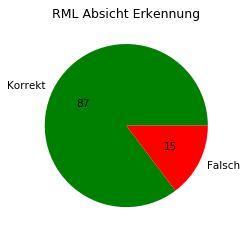

In [42]:
plt.figure(figsize=(4.8, 3.6), dpi=75)
plt.subplot()

labels = ['Korrekt', 'Falsch']
colors = ['g', 'r']
values = [luisIntentResults[k][0] for k in ['valid', 'invalid']]
total = sum(values)

plt.pie(values, labels=labels, colors=colors, autopct=lambda s: '{:.0f}'.format(s * total / 100))
plt.title('RML Absicht Erkennung')

display('NICHT IM BERICHT')
plt.show()

'NICHT IM BERICHT'

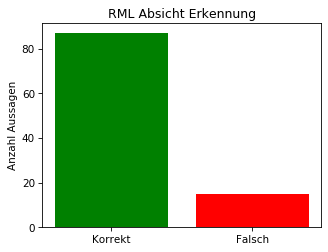

In [43]:
plt.figure(figsize=(4.8, 3.6), dpi=75)
plt.subplot()

labels = ['Korrekt', 'Falsch']
colors = ['g', 'r']
values = [luisIntentResults[k][0] for k in ['valid', 'invalid']]

plt.bar(labels, values, color=colors)
plt.title('RML Absicht Erkennung')
plt.ylabel('Anzahl Aussagen')

display('NICHT IM BERICHT')
plt.show()

**Sensitivity and Specificity of the RML intent recognition**

In [44]:
pd.DataFrame(rmlPerIntentResults)

,intent,truepos,trueneg,falsepos,falseneg
0,turn,13,76,0,13
1,flightlevel,21,74,2,5
2,squawk,24,76,0,2
3,contact,24,76,0,2


'NICHT IM BERICHT'

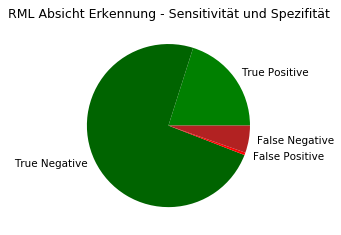

In [45]:
plt.figure(figsize=(4.8, 3.6), dpi=75)
plt.subplot()

labels = ['True Positive', 'True Negative', 'False Positive', 'False Negative']
colors = ['green',  'darkgreen', 'red', 'firebrick']
values = np.array([rmlPerIntentResults[c] for c in ['truepos','trueneg','falsepos','falseneg']]).sum(axis=1)

#labels = ['True Positive', 'False Positive', 'False Negative']
#colors = ['green',  'red', 'firebrick']
#values = np.array([rmlPerIntentResults[c] for c in ['truepos','falsepos','falseneg']]).sum(axis=1)

plt.title('RML Absicht Erkennung - Sensitivität und Spezifität')

plt.pie(values, labels=labels, colors=colors)

display('NICHT IM BERICHT')
plt.show()

'NICHT IM BERICHT'

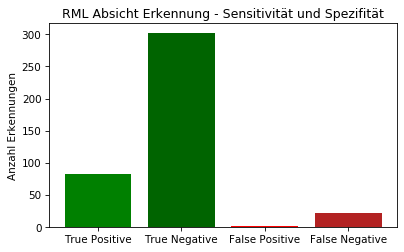

In [46]:
plt.figure(figsize=(6, 3.6), dpi=75)
plt.subplot()

labels = ['True Positive', 'True Negative', 'False Positive', 'False Negative']
colors = ['green',  'darkgreen', 'red', 'firebrick']
values = [sum(rmlPerIntentResults[c]) for c in ['truepos','trueneg','falsepos','falseneg']]


plt.title('RML Absicht Erkennung - Sensitivität und Spezifität')
plt.ylabel('Anzahl Erkennungen')

plt.bar(labels, values, color=colors)

display('NICHT IM BERICHT')
plt.show()

'NICHT IM BERICHT'

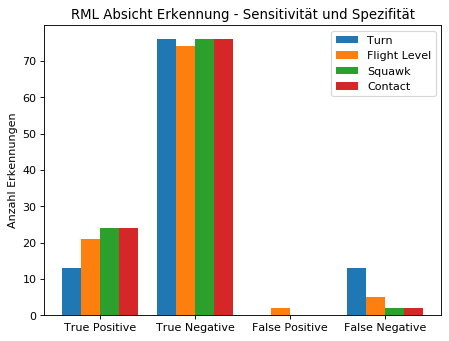

In [47]:
plt.figure(figsize=(6.4, 4.8), dpi=80)
plt.subplot()

N = 4

ind = np.arange(N) 
width = 0.2

for i in range(len(rmlPerIntentResults['intent'])):
    intentValues = [rmlPerIntentResults[c][i] for c in ['truepos','trueneg','falsepos','falseneg']]
    plt.bar(ind + (width * i), intentValues, width, label=intentLabels[rmlPerIntentResults['intent'][i]])

plt.ylabel('Anzahl Erkennungen')
plt.title('RML Absicht Erkennung - Sensitivität und Spezifität')

plt.xticks(ind + 1.5 * width, ('True Positive', 'True Negative', 'False Positive', 'False Negative'))
plt.legend(loc='best')

display('NICHT IM BERICHT')
plt.show()

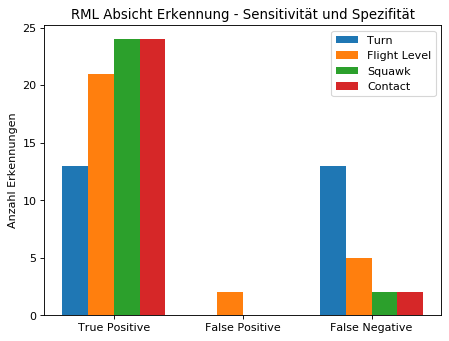

In [48]:
plt.figure(figsize=(6.4, 4.8), dpi=80)
plt.subplot()

N = 3

ind = np.arange(N) 
width = 0.2

for i in range(len(rmlPerIntentResults['intent'])):
    intentValues = [rmlPerIntentResults[c][i] for c in ['truepos','falsepos','falseneg']]
    plt.bar(ind + (width * i), intentValues, width, label=intentLabels[rmlPerIntentResults['intent'][i]])

plt.ylabel('Anzahl Erkennungen')
plt.title('RML Absicht Erkennung - Sensitivität und Spezifität')

plt.xticks(ind + 1.5 * width, ('True Positive', 'False Positive', 'False Negative'))
plt.legend(loc='best')
plt.show()

In [49]:
#plt.figure(figsize=(6.4, 4.8), dpi=80)
#plt.subplot()
#
#N = len(rmlPerIntentResults['intent'])
#
#ind = np.arange(N) 
#width = 0.2
#
#categoryKeys = ['truepos','trueneg','falsepos','falseneg']
#categoryLabels = ['True Positive', 'True Negative', 'False Positive', 'False Negative']
#
#for c in range(len(categoryKeys)):
#    categoryValues = [rmlPerIntentResults[categoryKeys[c]][i] for i in range(len(rmlPerIntentResults['intent']))]
#    plt.bar(ind + (width * c), categoryValues, width, label=categoryLabels[c])
#    
##plt.bar(ind, men_means, width, label='Men')
##plt.bar(ind + width, women_means, width, label='Women')
#
#plt.ylabel('Count')
#plt.title('Intent Recognition Sensitivity and Specificity')
#
#plt.xticks(ind + 1.5 * width, rmlPerIntentResults['intent'])
#plt.legend(loc='best')
#print('"Same" diagram, but different')
#plt.show()

## RML Version Compare

In [50]:
#intents = utils.flatten([l['intent'] for l in dataRmlVs.labels])
intents = list(set(intents))

rmlVsLabel = {
    'extracted-airline-nocheck': 'Ohne Check',
    'extracted-airline-check': 'Mit Check',
}

rmlVsCallsignResults = {v:{
    'fullCallSign': 0,
    'flightNumerOnly': 0,
    'airlineOnly': 0,
    'allInvalid': 0,
} for v in dataRmlVs.versions}

rmlVsCallSignDistance = {v:{
    'airline': {},
    'flightNumber': {},
} for v in dataRmlVs.versions}

for rec in dataRmlVs.datarecords:
    if rec.contexts is None:
        continue
    
    for version in dataRmlVs.versions:
        if rec.contexts[version] is None:
            continue
        
        rmlContext = rec.contexts[version][0]['RmlContext']
    
        # compare extracted data with labels
        rmlAirlineValid, rmlFlightnrValid, rmlAirlineLevenshtein, rmlFlightnrLevenshtein = ctutils.check_callsign(rmlContext, rec.label)

        # set rmlCallsignResults
        if rmlFlightnrValid and rmlAirlineValid:
            rmlVsCallsignResults[version]['fullCallSign'] += 1
        elif rmlFlightnrValid and not rmlAirlineValid:
            rmlVsCallsignResults[version]['flightNumerOnly'] += 1
        elif not rmlFlightnrValid and rmlAirlineValid:
            rmlVsCallsignResults[version]['airlineOnly'] += 1
        else:
            rmlVsCallsignResults[version]['allInvalid'] += 1

        key = str(int(rmlAirlineLevenshtein)) if rmlAirlineLevenshtein is not None and int(rmlAirlineLevenshtein) < 7 else '≥7'
        rmlVsCallSignDistance[version]['airline'][key] = rmlVsCallSignDistance[version]['airline'].get(key, 0) + 1
        key = str(int(rmlFlightnrLevenshtein)) if rmlFlightnrLevenshtein is not None and int(rmlFlightnrLevenshtein) < 7 else '≥7'
        rmlVsCallSignDistance[version]['flightNumber'][key] = rmlVsCallSignDistance[version]['flightNumber'].get(key, 0) + 1


In [51]:
# Rufzeichen Korrekt
# Flugnummer Korrekt, Fluggesellschaft Inkorrekt
# Flugnummer Inkorrekt, Fluggesellschaft Korrekt
# Alles Falsch
pd.DataFrame(rmlVsCallsignResults)

,extracted-airline-nocheck,extracted-airline-check
fullCallSign,69,67
flightNumerOnly,19,14
airlineOnly,12,9
allInvalid,2,12


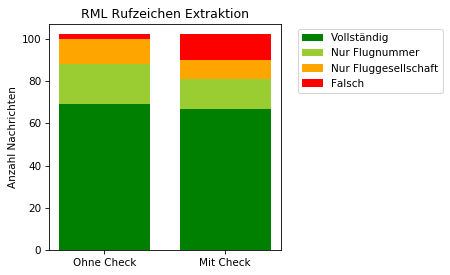

In [52]:
plt.figure(figsize=(4, 4), dpi=75)
plt.subplot()

labels = [rmlVsLabel[v] for v in dataRmlVs.versions]
width = 0.75
groups = zip(['fullCallSign','flightNumerOnly','airlineOnly','allInvalid'],
             ['Vollständig', 'Nur Flugnummer', 'Nur Fluggesellschaft', 'Falsch'],
             ['green',  'yellowgreen', 'orange', 'red'])

valueOffset = [0 for _ in labels]
for group in groups:
    key, label, color = group
    
    values = [rmlVsCallsignResults[v][key] for v in dataRmlVs.versions]
    
    plt.bar(labels, values, width, bottom=valueOffset, label=label, color=color)
    
    valueOffset = [a + b for a,b in zip(valueOffset, values)] # add values


plt.title('RML Rufzeichen Extraktion')
plt.ylabel('Anzahl Nachrichten')
plt.legend(bbox_to_anchor=(1.05, 1))

plt.show()

In [53]:
for v in dataRmlVs.versions:
    print('\n',rmlVsLabel[v] + ':')
    
    for k in rmlVsCallSignDistance[v].keys():
        display(pd.DataFrame({k: rmlVsCallSignDistance[v][k]}).sort_index())


 Ohne Check:


,airline
0,81
1,5
2,1
3,2
4,2
6,3
≥7,8


,flightNumber
0,88
1,10
3,3
4,1



 Mit Check:


,airline
0,76
1,5
2,1
3,6
5,1
6,2
≥7,11


,flightNumber
0,81
1,8
3,11
4,2


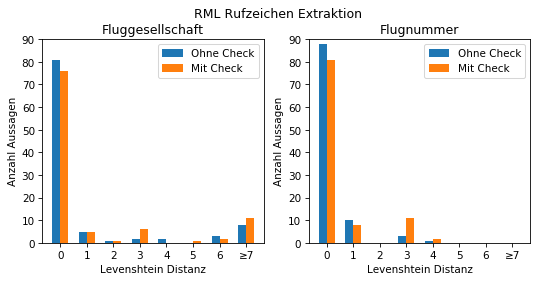

In [54]:
plt.figure(figsize=(8.4, 3.6), dpi=75)
plt.subplot(1, 2, 1)

labels = [str(k) for k in list(range(0,7))] + ['≥7']

N = len(labels)
ind = np.arange(N)
width = 0.3

i = 0
for v in dataRmlVs.versions:
    values = [rmlVsCallSignDistance[v]['airline'].get(ld, 0) for ld in labels]
    plt.bar(ind + (width * i), values, width, label=rmlVsLabel[v])
    
    i += 1 #increment for offset

plt.xticks(ind + 0.5 * width, labels)
plt.gca().yaxis.get_major_locator().set_params(integer=True)

plt.title('Fluggesellschaft')
plt.ylabel('Anzahl Aussagen')
plt.xlabel('Levenshtein Distanz')
plt.ylim(top=90)
plt.legend(loc='best')

plt.subplot(1, 2, 2)

i = 0
for v in dataRmlVs.versions:
    values = [rmlVsCallSignDistance[v]['flightNumber'].get(ld, 0) for ld in labels]
    plt.bar(ind + (width * i), values, width, label=rmlVsLabel[v])
    
    i += 1 #increment for offset

plt.xticks(ind + 0.5 * width, labels)
plt.gca().yaxis.get_major_locator().set_params(integer=True)

plt.title('Flugnummer')
plt.ylabel('Anzahl Aussagen')
plt.xlabel('Levenshtein Distanz')
plt.ylim(top=90)
plt.legend(loc='best')

plt.suptitle('RML Rufzeichen Extraktion', y=1)
plt.show()

## LUIS vs RML

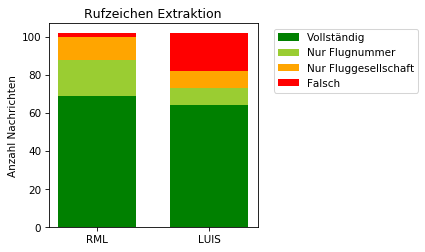

In [55]:
plt.figure(figsize=(3.6, 3.6), dpi=75)
plt.subplot()

labels = ('RML', 'LUIS')
width = 0.7
groups = zip(['fullCallSign','flightNumerOnly','airlineOnly','allInvalid'],
             ['Vollständig', 'Nur Flugnummer', 'Nur Fluggesellschaft', 'Falsch'],
             ['green',  'yellowgreen', 'orange', 'red'])

valueOffset = [0 for _ in labels]
for group in groups:
    key, label, color = group
    
    values = (rmlCallsignResults[key], luisCallsignResults[key])
    
    plt.bar(labels, values, width, bottom=valueOffset, label=label, color=color)
    
    valueOffset = [a + b for a,b in zip(valueOffset, values)] # add values


plt.title('Rufzeichen Extraktion')
plt.ylabel('Anzahl Nachrichten')
plt.legend(bbox_to_anchor=(1.05, 1))

plt.show()

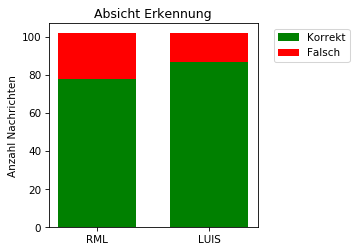

In [56]:
plt.figure(figsize=(3.6, 3.6), dpi=75)
plt.subplot()

labels = ('RML', 'LUIS')
width = 0.7
groups = zip(['valid', 'invalid'],
             ['Korrekt', 'Falsch'],
             ['g', 'r'])

valueOffset = [0 for _ in labels]
for group in groups:
    key, label, color = group
    
    values = (rmlIntentResults[key][0], luisIntentResults[key][0])
    
    plt.bar(labels, values, width, bottom=valueOffset, label=label, color=color)
    
    valueOffset = [a + b for a,b in zip(valueOffset, values)] # add values


plt.title('Absicht Erkennung')
plt.ylabel('Anzahl Nachrichten')
plt.legend(bbox_to_anchor=(1.05, 1))

plt.show()


'NICHT IM BERICHT'

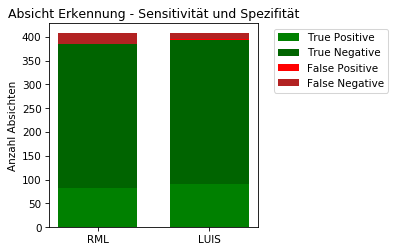

In [57]:
plt.figure(figsize=(3.6, 3.6), dpi=75)
plt.subplot()

labels = ('RML', 'LUIS')
width = 0.7

groups = zip(['truepos','trueneg','falsepos','falseneg'],
             ['True Positive', 'True Negative', 'False Positive', 'False Negative'],
             ['green',  'darkgreen', 'red', 'firebrick'])

valueOffset = [0 for _ in labels]
for group in groups:
    key, label, color = group
    
    values = (sum(rmlPerIntentResults[key]), sum(luisPerIntentResults[key]))
    
    plt.bar(labels, values, width, bottom=valueOffset, label=label, color=color)
    
    valueOffset = [a + b for a,b in zip(valueOffset, values)] # add values


plt.title('Absicht Erkennung - Sensitivität und Spezifität')
plt.ylabel('Anzahl Absichten')
plt.legend(bbox_to_anchor=(1.05, 1))

display('NICHT IM BERICHT')
plt.show()

'NICHT IM BERICHT'

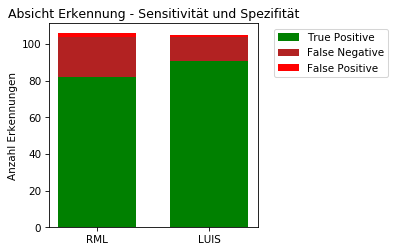

In [58]:
plt.figure(figsize=(3.6, 3.6), dpi=75)
plt.subplot()

labels = ('RML', 'LUIS')
width = 0.7

groups = zip(['truepos','falseneg','falsepos'],
             ['True Positive', 'False Negative', 'False Positive'],
             ['green', 'firebrick', 'red'])

valueOffset = [0 for _ in labels]
for group in groups:
    key, label, color = group
    
    values = (sum(rmlPerIntentResults[key]), sum(luisPerIntentResults[key]))
    
    plt.bar(labels, values, width, bottom=valueOffset, label=label, color=color)
    
    valueOffset = [a + b for a,b in zip(valueOffset, values)] # add values


plt.title('Absicht Erkennung - Sensitivität und Spezifität')
plt.ylabel('Anzahl Erkennungen')
plt.legend(bbox_to_anchor=(1.05, 1))

display('NICHT IM BERICHT')
plt.show()

## Auswertung

In [59]:
# todo: auswertung mit theoretischem Flugraum